# Tennis

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

The environment should be saved in the Workspace so that it can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Determine if GPU can be used

In [5]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 4. Define the actor network

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, n_agents, seed):
        """Initialize parameters and build model.
        Params
        ======
            seed (int): Random seed
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.n_agents = n_agents
        
        self.hidden_dim_0 = 512
        self.hidden_dim = 256
        
        self.lin0 = nn.Linear(state_size * self.n_agents, self.hidden_dim_0)
        self.lin0.weight.data.uniform_(-0.01, 0.01)
        self.lin1 = nn.Linear(self.hidden_dim_0, self.hidden_dim)
        self.lin1.weight.data.uniform_(-0.01, 0.01)
        self.lin2 = nn.Linear(self.hidden_dim, action_size * self.n_agents)
        self.lin2.weight.data.uniform_(-0.01, 0.01)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = state.view(-1, state_size * self.n_agents) # collapse the agents' states into one big state for the NN
        x = F.relu(self.lin0(x))
        x = F.relu(self.lin1(x))
        x = F.tanh(self.lin2(x))
        return x.view(-1, self.n_agents, action_size) # uncollapse to have one action for each agent 

### 5. Define the Critic network

In [7]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, n_agents, seed):
        """Initialize parameters and build model.
        Params
        ======
            seed (int): Random seed
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.n_agents = n_agents
        
        self.hidden_dim_0 = 512
        self.hidden_dim = 256
        
        self.lin0 = nn.Linear(state_size * self.n_agents, self.hidden_dim_0)
        self.lin0.weight.data.uniform_(-0.01, 0.01)
        self.lin1 = nn.Linear(self.hidden_dim_0 + action_size * self.n_agents, self.hidden_dim)
        self.lin1.weight.data.uniform_(-0.01, 0.01)
        self.lin2 = nn.Linear(self.hidden_dim, 1) # one single number as output
        self.lin2.weight.data.uniform_(-0.01, 0.01)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = state.view(-1, state_size * self.n_agents) # collapse the agents' states into one big state for the NN
        action = action.view(-1, action_size * self.n_agents)
        x = F.relu(self.lin0(x))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.lin1(x))
        return self.lin2(x)

### 6. Define some hyper parameters

In the following cell we define hyper parmeters and constants for the learning algorithm.

In [8]:
n_episodes = 3000
replay_buffer_size = 100000
batch_size = 128
gamma = 0.99
learning_rate = 0.0001
tau = 0.1

target_score = 0.5
seed = 42

### 7. Noise for exploration

A simple helper class to generate noise based on the Ornstein-Uhlenbeck process. This is used to explore the action space.


In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = np.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

### 8. The replay buffer

A simple helper class for storing experience tuples and randomly draw samples from them.


In [10]:
from collections import namedtuple, deque, Counter

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.asarray([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.asarray([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.asarray([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.asarray([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.asarray([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 9. Define the Agents
The two agents are combined in one class

In [11]:
import random 

class Agents():
    """Interact with and learns from the environment."""
    
    def __init__(self, n_agents, random_seed):  
        """Initialize an Agents object.
        
        Params
        ======
            n_agents (int): the number of agents
            random_seed (int): random seed
        """
       
        self.n_agents = n_agents
        self.seed = random.seed(random_seed)

        self.actor_local = Actor(n_agents, random_seed).to(device)
        self.actor_target = Actor(n_agents, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=learning_rate)

        self.critic_local = Critic(n_agents, random_seed).to(device)
        self.critic_target = Critic(n_agents, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=learning_rate)

        self.noise = OUNoise((n_agents, action_size), random_seed)
        self.memory = ReplayBuffer(replay_buffer_size, batch_size, random_seed)
    
    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device) 

        self.actor_local.eval()

        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()            

        self.actor_local.train()
        
        action += self.noise.sample() # add noise to explore action space
        action = np.clip(action, -1, 1)
        return action
    
    def reset(self):
        self.noise.reset()
    
    def step(self, state, action, reward, next_state, done):
        # store all agents' experience tuples
        self.memory.add(state, action, reward, next_state, done)
            
        # if there are enough tuples, get a sample and learn from it
        if len(self.memory) >= batch_size:
            samples = self.memory.sample()
            self.learn(*samples)

    def learn(self, states, actions, rewards, next_states, dones):

        next_actions = self.actor_target(next_states) # predict actions
        next_targets = self.critic_target(next_states, next_actions) # predict max Q values for next state    
        targets = rewards + (gamma * next_targets * (1 - dones)) # Q values for current state
               
        # Compute critic loss
        expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(expected, targets)
        
        # critic step
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1.0) # gradients tend to get too large, so clip them
        self.critic_optimizer.step()

        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()

        # actor step
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1.0) # gradients tend to get too large, so clip them
        self.actor_optimizer.step()

        # update target networks
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target)                  

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to) 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### 10. The Algorithm (DDPG)

In [ ]:
from collections import deque

scores = []
scores_window = deque(maxlen=100)
solved = False
epsilon = -1

env_info = env.reset(train_mode=True)[brain_name]
n_agents = len(env_info.agents)
agents = Agents(n_agents, seed)

for episode in range(1, 1 + n_episodes):
    env_info = env.reset(train_mode=True)[brain_name]
    
    state = env_info.vector_observations   
    agents.reset()
    
    score = np.zeros(n_agents)
    done = [False]

    while not np.any(done):
        action = agents.act(state)[0]
        env_info = env.step(np.concatenate((action[0], action[1])))[brain_name] # apply action in environment

        next_state = env_info.vector_observations
        reward = env_info.rewards
        done = env_info.local_done
        
        # make the agents learn
        agents.step(state, action, reward, next_state, done)
        
        score += reward
        state = next_state

    scores.append(np.max(score))
    scores_window.append(np.max(score))
    
    avg_score = np.mean(scores_window)
    if avg_score > target_score:
        torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
        np.save('scores05.npy', np.array(scores))
        if episode > 100 and not solved:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(episode, np.mean(scores_window)))

    print('\rEpisode {}\tAverage Score: {:.4f}'.format(episode, np.mean(scores_window)), end="")
    if episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(episode, np.mean(scores_window)))
        
env.close()

Episode 100	Average Score: 0.0048
Episode 200	Average Score: 0.0166
Episode 300	Average Score: 0.0966
Episode 400	Average Score: 0.1245
Episode 500	Average Score: 0.1498
Episode 600	Average Score: 0.1479
Episode 700	Average Score: 0.2049
Episode 800	Average Score: 0.2390
Episode 900	Average Score: 0.2607
Episode 1000	Average Score: 0.2708
Episode 1100	Average Score: 0.3417
Episode 1200	Average Score: 0.3395
Episode 1300	Average Score: 0.4676
Episode 1340	Average Score: 0.4984
Environment solved in 1341 episodes!	Average Score: 0.5054
Episode 1400	Average Score: 0.4635
Episode 1500	Average Score: 0.3647
Episode 1600	Average Score: 0.4285
Episode 1700	Average Score: 0.2715
Episode 1800	Average Score: 0.4328
Episode 1900	Average Score: 0.3368
Episode 2000	Average Score: 0.3652
Episode 2042	Average Score: 0.3641

### 11. Plot the score history

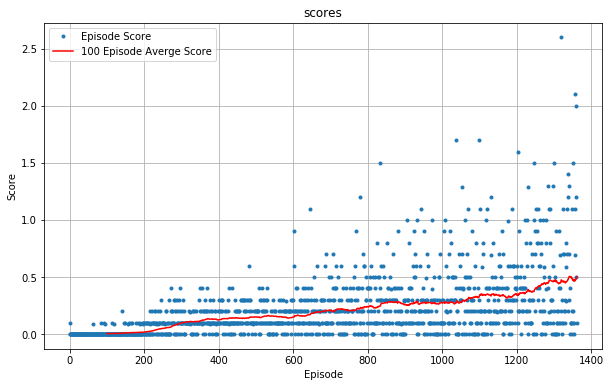

In [3]:
import matplotlib.pyplot as plt
import numpy as np

scores = np.load('scores05.npy')

means = []
for i in range(100, len(scores)):
    means.append([i, np.mean(scores[i-100:i])])
means = np.array(means)
plt.figure(figsize=(10, 6))
plt.plot(scores ,'.')
plt.plot(means[:, 0],means[:, 1],'r')
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('scores')
plt.legend(['Episode Score', '100 Episode Averge Score'])